In [1]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

In [36]:
from multisoc.generate.multidimensional_network import multidimensional_network_fix_av_degree
from multisoc.generate.two_dimensional_population import consol_comp_pop_frac_tnsr
from multisoc.generate.utils import make_composite_index
from multisoc.theory.multidimensional_preferences import composite_H
from multisoc.metrics.fairness_metrics import *
from multisoc.theory.fairness_metrics import *

# Synthetic networks

### Generate network

In [3]:
## List of 1d homophily matrices (2 for a two-dimensional system)
h_mtrx_lst = [ 
    np.array([[0.9,0.1],
              [0.1,0.9]]),
    np.array([[0.6,0.4],
              [0.4,0.6]])
]

## The marginals of the population distribution defined by comp_pop_frac_tnsr
## Each row has to sum 1 (100% of the population)
pop_fracs_lst = [
    [0.2,0.8],
    [0.4,0.6]
]

## Generate population distribution with certain level of corrrelation
## No correlation would correspond to the fraction of the largest minority
consol = 0.4 ## Level of correlation - neutral correlation corresponds to the size of the largest minority out of the two minority groups in the two dimensions (0.4 in this example)
comp_pop_frac_tnsr = consol_comp_pop_frac_tnsr(pop_fracs_lst,consol)

N = 200 ## Number of nodes
m = 20  ## Average number of connections per node

kind = "all" ## Aggregation function: {all->and, one->mean, any->or}
p_d = [0.5, 0.5] ## Weight of each dimension for "mean" aggregation function

G = multidimensional_network_fix_av_degree(
                h_mtrx_lst,
                comp_pop_frac_tnsr,
                kind,
                directed=True, ## Directed or undirected network
                pop_fracs_lst = pop_fracs_lst,
                N=N,
                m=m,
                v = 0,
                p_d = p_d
                )

In [4]:
## Remove isolated nodes and compute positions of nodes
G.remove_nodes_from(list(nx.isolates(G)))
pos = nx.kamada_kawai_layout(G,scale=3)

In [5]:
color_dict = {
    (0,0):"#84e8af",
    (0,1):"#c0cdf9",
    (1,0):"#f0cd6f",
    (1,1):"#ffabb0"
    }
nodelist = G.nodes()
node_colors = [color_dict[G.nodes[i]["attr"]] for i in nodelist]
n = len(G.nodes())
node_size = 40000*(1/(n+200))

degs = np.array([G.degree()[i] for i in nodelist])
node_size_list =  node_size*0.1+(node_size*4-node_size*0.1)*(degs-min(degs))/(max(degs)-min(degs))

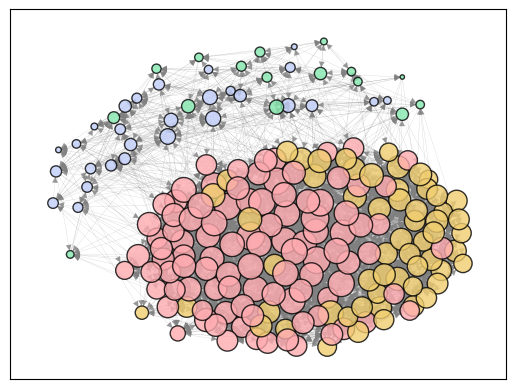

In [7]:
## Draw network
nx.draw_networkx(G,
                     with_labels = False,
                     pos=pos,
                     nodelist=nodelist,
                     node_color=node_colors,
                     # node_size=node_size_list, ## 
                     # node_shape=shape_dict[key],
                     width=0.1,
                     alpha = .8,
                     arrowstyle = '-|>',
                     linewidths = 1,
                     edgecolors = 'black',
                     edge_color = 'grey', ## v2
                     # ax=ax
                )
plt.show()

### Measure inequalities in synthetic network

In [10]:
g_vec = [2,2]
full_ineq_dict = get_inequality_info_from_graph(G,g_vec,attribute_key="attr",ineq_fun=common_language_delta)
full_ineq_dict

{'dim0_g0': -0.9883449883449883,
 'dim0_g1': 0.988344988344988,
 'dim0_(0, 0)': 0.0,
 'dim0_(0, 1)': -0.9883449883449883,
 'dim0_(1, 0)': 0.988344988344988,
 'dim0_(1, 1)': 0.0,
 'dim1_g0': -0.1927284427284427,
 'dim1_g1': 0.19272844272844258,
 'dim1_(0, 0)': 0.0,
 'dim1_(0, 1)': -0.1927284427284427,
 'dim1_(1, 0)': 0.19272844272844258,
 'dim1_(1, 1)': 0.0,
 'multi(0, 0)': -0.8532608695652174,
 'multi((0, 0), (0, 0))': 0.0,
 'multi((0, 0), (0, 1))': -0.0915178571428571,
 'multi((0, 0), (1, 0))': -0.9741379310344828,
 'multi((0, 0), (1, 1))': -0.9993622448979592,
 'multi(0, 1)': -0.8870431893687707,
 'multi((0, 1), (0, 0))': 0.0915178571428572,
 'multi((0, 1), (0, 1))': 0.0,
 'multi((0, 1), (1, 0))': -0.9698275862068966,
 'multi((0, 1), (1, 1))': -0.9978134110787172,
 'multi(1, 0)': 0.08681398737251089,
 'multi((1, 0), (0, 0))': 0.9741379310344831,
 'multi((1, 0), (0, 1))': 0.9698275862068968,
 'multi((1, 0), (1, 0))': 0.0,
 'multi((1, 0), (1, 1))': -0.31034482758620685,
 'multi(1, 1)':

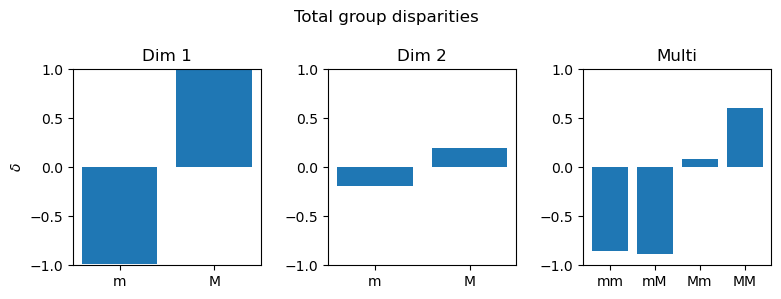

In [57]:
## Plot inequalities
plt.figure(figsize=(8,3))

plt.suptitle("Total group disparities")

plt.subplot(1,3,1)
plt.title("Dim 1")
plt.bar(["m","M"],[full_ineq_dict["dim0_g0"],full_ineq_dict["dim0_g1"]])
plt.ylim(-1,1)
plt.ylabel(r"$\delta$")

plt.subplot(1,3,2)
plt.title("Dim 2")
plt.bar(["m","M"],[full_ineq_dict["dim1_g0"],full_ineq_dict["dim1_g1"]])
plt.ylim(-1,1)

plt.subplot(1,3,3)
plt.title("Multi")
plt.bar(["mm","mM","Mm","MM"],[full_ineq_dict["multi(0, 0)"],full_ineq_dict["multi(0, 1)"],full_ineq_dict["multi(1, 0)"],full_ineq_dict["multi(1, 1)"]])
plt.ylim(-1,1)

plt.tight_layout()
plt.show()

### Compute analytical predicted inequalities

In [37]:
H = composite_H(h_mtrx_lst,"all")
F = comp_pop_frac_tnsr
predicted_onedime_ineq = analytical_1vRest_onedimensional_deltas(H,F,N)
predicted_multi_ineq = analytical_1vRest_multidimensional_deltas(H,F,N)

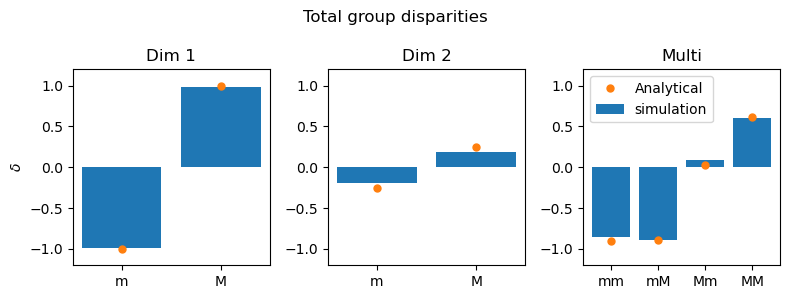

In [58]:
plt.figure(figsize=(8,3))

plt.suptitle("Total group disparities")

plt.subplot(1,3,1)
plt.title("Dim 1")
plt.bar(["m","M"],[full_ineq_dict["dim0_g0"],full_ineq_dict["dim0_g1"]])
plt.plot([0,1],[predicted_onedime_ineq[0][0],predicted_onedime_ineq[0][1]],"o",color="C1",ms=5)
plt.ylim(-1.2,1.2)
plt.ylabel(r"$\delta$")

plt.subplot(1,3,2)
plt.title("Dim 2")
plt.bar(["m","M"],[full_ineq_dict["dim1_g0"],full_ineq_dict["dim1_g1"]])
plt.plot([0,1],[predicted_onedime_ineq[1][0],predicted_onedime_ineq[1][1]],"o",color="C1",ms=5)
plt.ylim(-1.2,1.2)

plt.subplot(1,3,3)
plt.title("Multi")
plt.bar(["mm","mM","Mm","MM"],
        [full_ineq_dict["multi(0, 0)"],full_ineq_dict["multi(0, 1)"],full_ineq_dict["multi(1, 0)"],full_ineq_dict["multi(1, 1)"]],
        label="simulation")
plt.plot([0,1,2,3],[predicted_multi_ineq[(0, 0)],predicted_multi_ineq[(0, 1)],predicted_multi_ineq[(1, 0)],predicted_multi_ineq[(1, 1)]],"o",color="C1",ms=5,label="Analytical")
plt.ylim(-1.2,1.2)

plt.legend()
plt.tight_layout()
plt.show()